# Imports

In [2]:
import os
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
import pickle
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

# Load Data 

In [3]:
# Create lists of vehicles and non-vehicles
# Images are divided up into vehicles and non-vehicles folders which also contain subfolders

# Locate vehicle images
basedir = 'vehicles/'
# Different folders represent different sources for images
image_types = os.listdir(basedir)
vehicles = []
for imtype in image_types:
    vehicles.extend(glob.glob(basedir+imtype+'/*'))
    
print('Number of Vehicle Images found:', len(vehicles))
with open('vehicles.txt', 'w') as f:
    for fn in vehicles:
        f.write(fn + '\n')
        
# Locate non-vehicle images
basedir = 'non-vehicles/'
# Different folders represent different sources for images
image_types = os.listdir(basedir)
non_vehicles = []
for imtype in image_types:
    non_vehicles.extend(glob.glob('non-vehicles/'+imtype+'/*'))

print('Number of Non-Vehicle Images found:', len(non_vehicles))
with open('non_vehicles.txt', 'w') as f:
    for fn in non_vehicles:
        f.write(fn + '\n')

Number of Vehicle Images found: 8792
Number of Non-Vehicle Images found: 8968


# Plot Examples

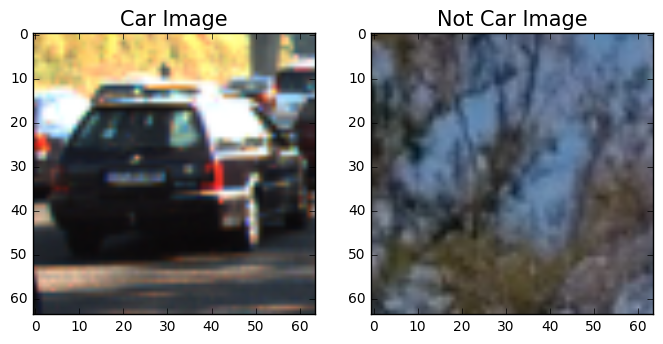

In [126]:
# Choose a random indices for plotting
vehicle_idx = np.random.randint(0, len(vehicles))
nonvehicles_idx = np.random.randint(0, len(non_vehicles))

# Read vehicle and non-vehicle image
vehicle_image = mpimg.imread(vehicles[vehicle_idx])
nonvehicle_image = mpimg.imread(non_vehicles[nonvehicles_idx])

# Plot an example of a vehicle and non-vehicle image 
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
ax1.imshow(vehicle_image)
ax1.set_title('Car Image', fontsize=15)
ax2.imshow(nonvehicle_image)
ax2.set_title('Not Car Image', fontsize=15)
plt.savefig('output_images/car_and_notcar.png')

# Definition of Functions

In [4]:
# Function that returns HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Function that computes binned color features
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    # Return the feature vector
    return np.hstack((color1, color2, color3))

# Function that computes color histogram features
def color_hist(img, nbins=32):    
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Function to extract features from a list of images
# This function calls the functions bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # Apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Compute spatial features if flag is set
        if spatial_feat == True:
            # Apply bin_spatial()
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            # Append features to list
            file_features.append(spatial_features)
        
        # Compute histogram features if flag is set
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            # Append features to list
            file_features.append(hist_features)
        
        # Compute HOG features if flag is set
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Function that takes an image, a list of bounding boxes, 
# and optional color tuple and line thickness as inputs
# then draws boxes in that color on the output
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw each bounding box(rectangle) on image copy given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

# Function that extracts features from a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, pix_per_cell=8, 
                        cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, 
                        hog_feat=True, vis=False):    
    # Define an empty list to receive features
    img_features = []
    # Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    # Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Append features to list
        img_features.append(spatial_features)
    # Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        # Append features to list
        img_features.append(hist_features)
    # Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  
            hog_features = np.concatenate(hog_features)
        else:
            if vis == True:
                hog_features, hog_image = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                           orient, pix_per_cell, cell_per_block, 
                                                           vis=False, feature_vec = True)
        # Append features to list
        img_features.append(hog_features)
    
    if vis == True:
        return np.concatenate(img_features), hog_image
    else:
        # Return concatenated array of features
        return np.concatenate(img_features)

    
# Function that passes an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    # Create an empty list to receive positive detection windows
    on_windows = []
    # Iterate over all windows in the list
    for window in windows:
        # Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        # Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        # Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        # Predict using your classifier
        prediction = clf.predict(test_features)
        # If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    # Return windows for positive detections
    return on_windows

# Function to plot images 
def plot_figure(original_img, test_img, idx):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    
    ax1.imshow(original_img)
    ax1.set_title('Original Image {0}'.format(idx+1), fontsize=30)
    ax1.tick_params(axis='both', which='major', labelsize=30)
    
    ax2.imshow(test_img, cmap='hot')
    ax2.set_title('New Image {0}'.format(idx+1), fontsize=30)
    ax2.tick_params(axis='both', which='major', labelsize=30)
    
# Function for plotting multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap='hot')
            plt.title(titles[i])
        else:
            plt.imshow(img)
            plt.title(titles[i])


# HOG Features Visualization

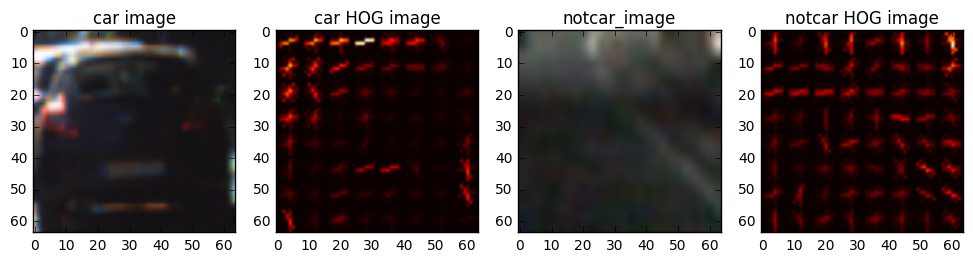

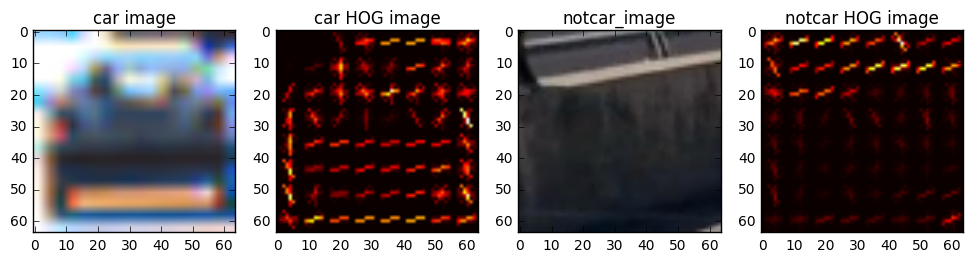

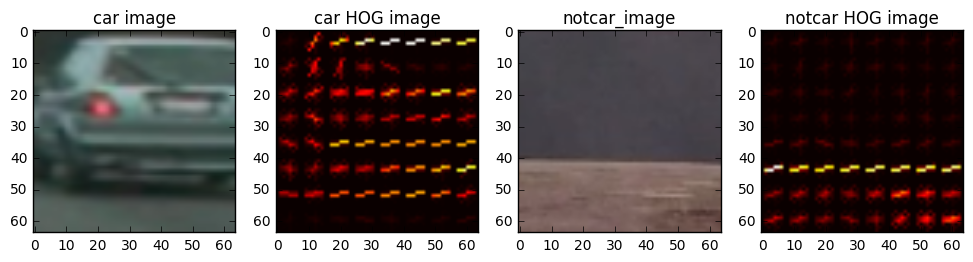

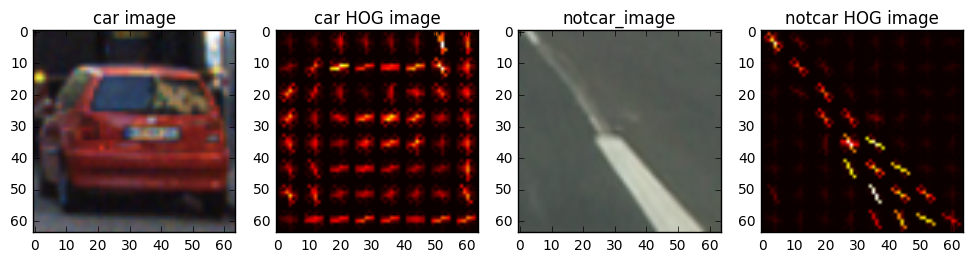

In [154]:
# Define features parameters
color_space = 'RGB' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 2 # 0,1,2 or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



# Extract HOG Features from random images of car and not-car images and visualize them
for i in range(0,4):
    # Choose random car / not-car indices
    car_ind = np.random.randint(0, len(vehicles))
    notcar_ind = np.random.randint(0, len(non_vehicles))

    # Read in car / not-car images
    car_image = mpimg.imread(vehicles[car_ind])
    notcar_image = mpimg.imread(non_vehicles[notcar_ind])

    # Extract single image features
    car_features, car_hog_image = single_img_features(car_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    notcar_features, notcar_hog_image = single_img_features(notcar_image, color_space=color_space, spatial_size=spatial_size, 
                        hist_bins=hist_bins, orient=orient,
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, 
                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    # Visualize HOG Features on single images
    images = [car_image, car_hog_image, notcar_image, notcar_hog_image]
    titles = ['car image', 'car HOG image', 'notcar_image', 'notcar HOG image']
    fig = plt.figure(figsize=(12,3))
    visualize(fig, 1, 4, images, titles)
    plt.savefig('output_images/HOG_Features'+str(i)+'.png')

# Classifier Training

In [5]:
# Define features parameters
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 0,1,2 or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
test_cars = vehicles
test_notcars = non_vehicles

# Extract features
car_features = extract_features(test_cars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Define features vector 
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler 
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)

# Split the data into randomized training and test sets 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
     'pixels per cell,', cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC
svc = LinearSVC()

# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
print(round(time.time()-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Save SVC result for later use
pickle.dump( svc, open( "./svc_pickle1.p", "wb" ) )
print('Saved SVC result')

61.57577395439148 Seconds to compute features...
Using: 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460
5.98 Seconds to train SVC...
Test Accuracy of SVC =  0.9907
Saved SVC result


In [5]:
# Define features parameters
color_space = 'YCrCb' # RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # 0,1,2 or 'ALL'
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

t = time.time()
test_cars = vehicles
test_notcars = non_vehicles

# Extract features
car_features = extract_features(test_cars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(test_notcars, color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)

print(time.time()-t, 'Seconds to compute features...')

# Define features vector 
X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler 
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

66.07508373260498 Seconds to compute features...


In [21]:
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)

# Split the data into randomized training and test sets 
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size = 0.2, random_state=rand_state)

print('Using:',orient,'orientations,',pix_per_cell,
     'pixels per cell,', cell_per_block, 'cells per block,', hist_bins, 'histogram bins, and', spatial_size, 'spatial sampling')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations, 8 pixels per cell, 2 cells per block, 32 histogram bins, and (32, 32) spatial sampling
Feature vector length: 8460


## Example of Feature Scaling Used for Training

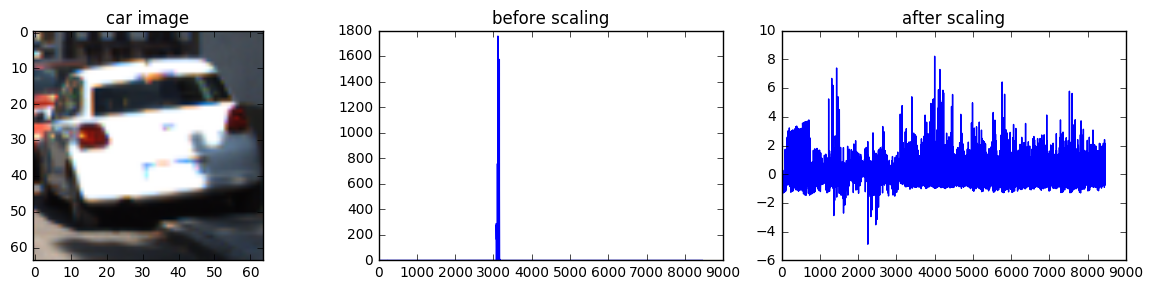

In [16]:
# Choose a random car index
vehicle_idx = np.random.randint(0, len(vehicles))

# Read in car / not-car images
car_image = mpimg.imread(vehicles[vehicle_idx])

# Plot example of features before and after training
fig = plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.imshow(car_image)
plt.title('car image')
plt.subplot(1,3,2)
plt.plot(X[vehicle_idx])
plt.title('before scaling')
plt.subplot(1,3,3)
plt.plot(scaled_X[vehicle_idx])
plt.title('after scaling')
fig.tight_layout()
plt.savefig('output_images/scaling.png')

## Load Best SVC Result

In [24]:
# Load SVC result 
svc = pickle.load( open("svc_pickle1.p", "rb" ) )
print('Loaded SVC result')

test_acc = round(svc.score(X_test,y_test), 4)
print('Test Accuracy of SVC = ', test_acc)

Loaded SVC result
Test Accuracy of SVC =  0.9986


# Vehicle Detection Using Trained Classifier

## Original Sliding Windows Method

0.41623520851135254 seconds to process on image searching 12 windows
0.4203774929046631 seconds to process on image searching 12 windows
0.41368699073791504 seconds to process on image searching 12 windows
0.4021275043487549 seconds to process on image searching 12 windows
0.4025113582611084 seconds to process on image searching 12 windows
0.4066135883331299 seconds to process on image searching 12 windows


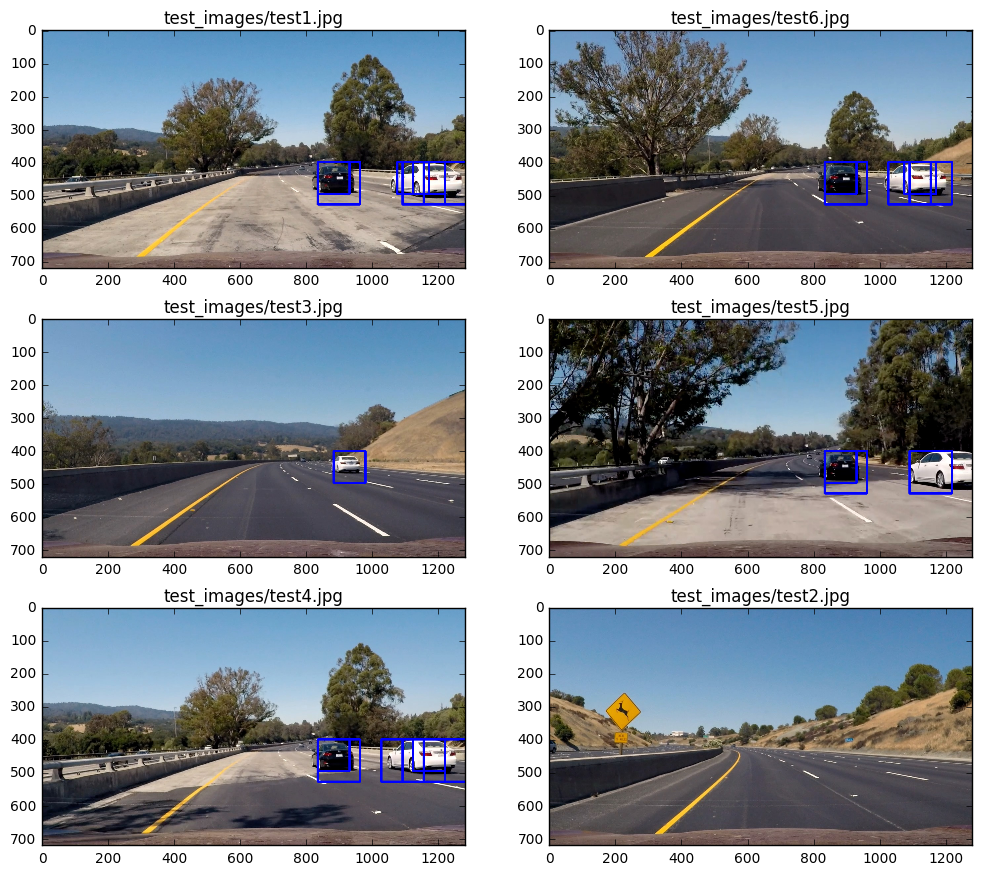

In [30]:
# Draw multiple bounding boxes for each detection 

# Test sliding windows on test images
example_images = glob.glob('test_images/*')
titles = []
images = []
y_start_stop = [400, 656] # Min and Max in y to search in slide_window()
overlap = 0.5 # Overlap of windows

# Go through each test image and apply sliding windows method to detect cars
for img_src in example_images:
    t = time.time()
    img = mpimg.imread(img_src)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    windows = slide_window(img, x_start_stop=[400, 1280], y_start_stop=[400, 600],
                          xy_window = (96, 96), xy_overlap=(overlap, overlap))
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat)
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window = (128, 128), xy_overlap=(overlap, overlap))
    
    hot_windows.extend(search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat))
    
    windows = slide_window(img, x_start_stop=[None, None], y_start_stop=y_start_stop,
                          xy_window = (192, 192), xy_overlap=(overlap, overlap))
    
    hot_windows.extend(search_windows(img, windows, svc, X_scaler, color_space=color_space,
                                spatial_size=spatial_size, hist_bins=hist_bins,
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block,
                                hog_channel=hog_channel, spatial_feat=spatial_feat,
                                hist_feat=hist_feat, hog_feat=hog_feat))
    
    window_img = draw_boxes(draw_img, hot_windows, color = (0,0,255), thick = 6)
    images.append(window_img)
    titles.append(img_src)
    
    # Check processing time for each image
    print(time.time()-t, 'seconds to process on image searching', len(windows), 'windows')
    
# Visualize boxes on images
fig = plt.figure(figsize=(12, 18), dpi = 300)
visualize(fig, 5, 2, images, titles)
plt.savefig('output_images/original_sliding_windows.png')

## Modified Sliding Windows Method

In [91]:
# Function that detects cars in the image
# Image is resized to a certian scale
def find_cars(img, scale, step):
    draw_img = np.copy(img) # Copy of image 
    img_boxes = [] # Array that holds boxes 
    heatmap = np.zeros_like(img[:,:,0]) # Make a heatmap of zeroes
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop, xstart:xstop, :] # Define search area 
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb) # Convert to appropriate color space 
    
    # Resize search area of image if scale is not equal to 1 
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # Color channels to use
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    # Number of blocks in the x and y direction
    nxblocks = (ch1.shape[1] // pix_per_cell) - 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - 1
    
    window = 64 # Window size 
    nblocks_per_window = (window // pix_per_cell) - 1 # Number of blocks per window 
    cells_per_step = step # Number of cells per step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step # Number of steps in the x direction
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step # Number of steps in the y direction
    
    # Compute HOG features for each color channel in the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Go through each step in both the x and y direction for patch of image 
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step # Current y position
            xpos = xb*cells_per_step # Current x position 
            
            # Extract HOG features for each color channel in the patch 
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell # Left position on the x-axis 
            ytop = ypos*pix_per_cell # Top position on the y-axis
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (32, 32))
            
            # Get color features 
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1,-1))
            test_prediction = svc.predict(test_features)
            
            # Draw box on the image and add heat to heatmap if test_prediction equals 1 
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img, (xbox_left+xstart, ytop_draw+ystart), (xbox_left + win_draw + xstart, ytop_draw + win_draw + ystart), (0,0,255))
                img_boxes.append(((xbox_left+xstart, ytop_draw+ystart), (xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))
                heatmap[ytop_draw + ystart : ytop_draw + win_draw + ystart, xbox_left + xstart: xbox_left + win_draw + xstart] += 1
                
    return draw_img, img_boxes, heatmap

In [92]:
from scipy.ndimage.measurements import label

# Function that draws boxes of detected cars in image
def draw_labeled_bboxes(img, labels):
    # Go through each detected car
    for car_number in range(1, labels[1]+1):
        # Find pixels where car is detected 
        nonzero = (labels[0] == car_number).nonzero()
        
        # X and y values of detected pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Create bounding box based on min/max values of x and y 
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        
        # Draw box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    
    return img

0.9868752956390381 seconds to process test image
0.867743968963623 seconds to process test image
0.8524138927459717 seconds to process test image
0.8570666313171387 seconds to process test image
0.9473345279693604 seconds to process test image
0.8674650192260742 seconds to process test image
Height of Images:  720
Width of Images:  1280


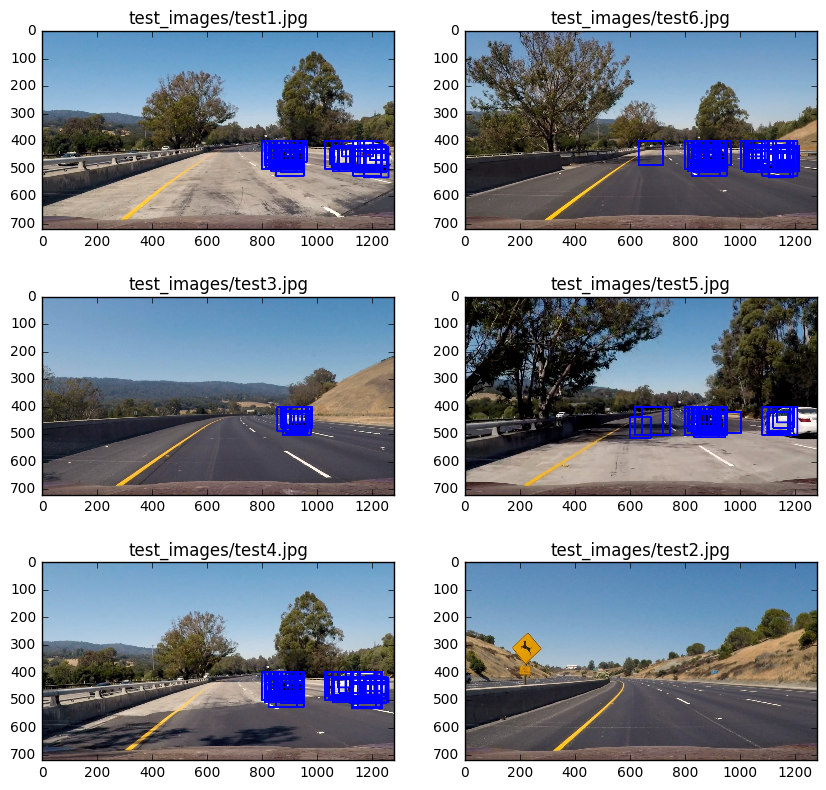

In [93]:
# Draw multiple bounding boxes for each detection

out_images = [] # Array for output images
out_titles = [] # Array for output plot titles

# Search Area for Image
ystart = 400
ystop = 656
xstart = 540
xstop = 1280

# Go through each test image and apply find_cars() function that uses modified sliding windows method to detect cars
for img_src in example_images:
    t = time.time() # Start time 
    img = mpimg.imread(img_src) # Read image 
    
    # Detect cars at different scales and steps 
    out_img1, img_boxes1, heat_map1 = find_cars(img, 0.9, step=2)
    out_img2, img_boxes2, heat_map2 = find_cars(img, 1.4, step=2)
    out_img3, img_boxes3, heat_map3 = find_cars(img, 1.2, step=2)
    out_img4, img_boxes4, heat_map4 = find_cars(img, 1.6, step=2)
    
    # Check processing time for each image
    print(time.time()-t, 'seconds to process test image')
    
    # Append all boxes found 
    img_boxes = img_boxes1 + img_boxes2 + img_boxes3 + img_boxes4
    
    # Draw boxes onto image
    window_img = draw_boxes(np.copy(img), img_boxes)
    
    out_images.append(window_img) # Append output image 
    out_titles.append(img_src) # Append output plot title 
    
# Visualize boxes on images
print("Height of Images: ", img.shape[0])
print("Width of Images: ", img.shape[1])
fig = plt.figure(figsize=(10, 20), dpi = 300)
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/mod_sliding_windows.png')

## Apply Heatmap 

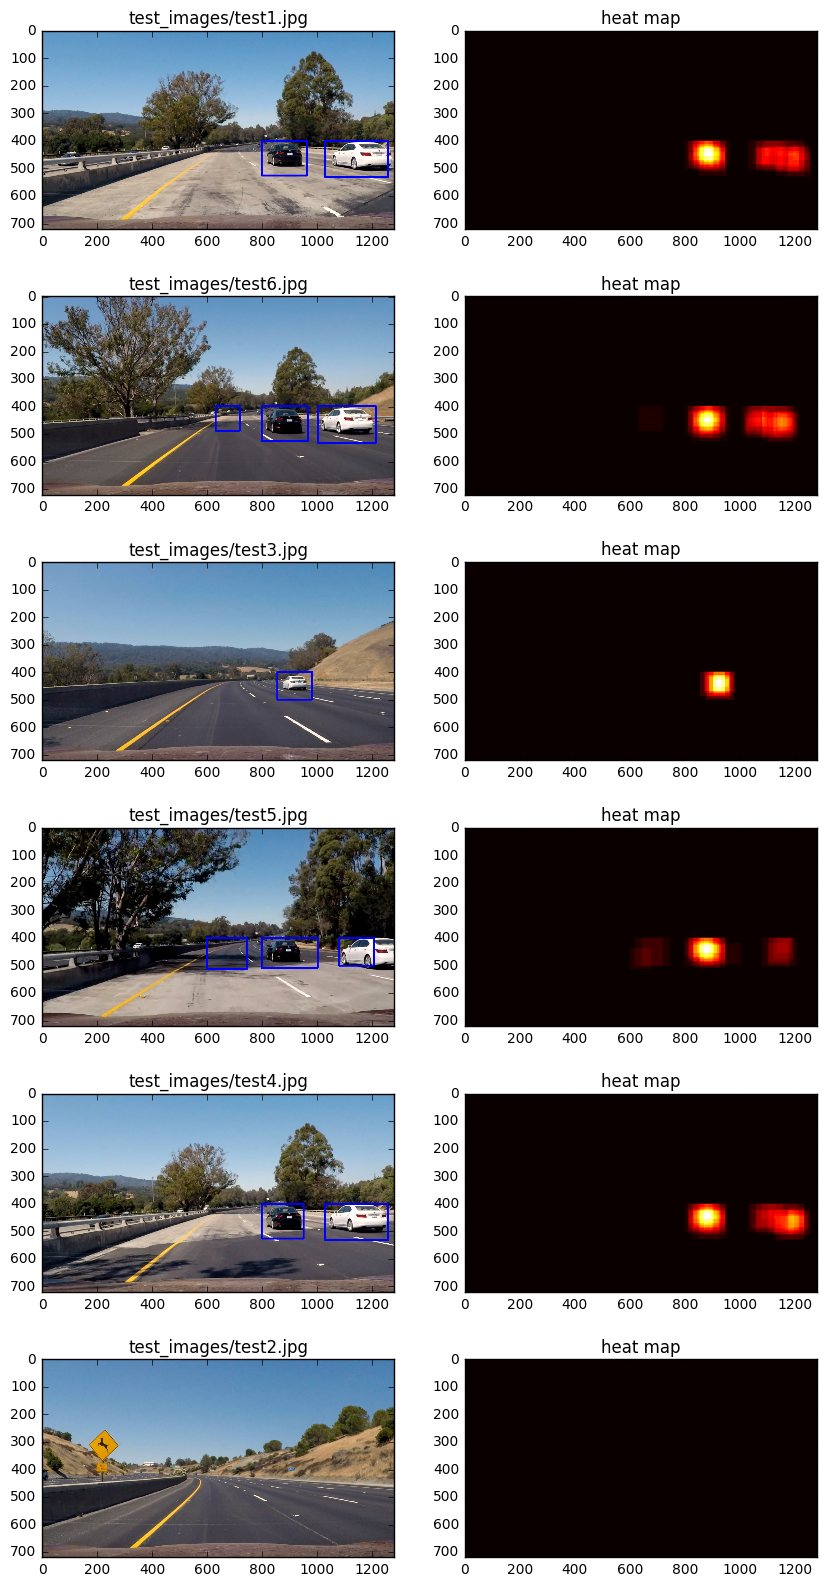

In [94]:
# Draw single bounding boxes over each detection using a heatmap to identify clusters of hotspots

out_images = [] # Array for output images
out_titles = [] # Array for output plot titles

# Search Area for Image
ystart = 400
ystop = 656
xstart = 540
xstop = 1280

# Go through each test image and apply find_cars() function that uses modified sliding windows method to detect cars
for img_src in example_images:
    img = mpimg.imread(img_src) # Read image 
    
    # Detect cars at different scales and steps 
    out_img, img_boxes, heat_map1 = find_cars(img, 0.9, step=2)
    out_img, img_boxes, heat_map2 = find_cars(img, 1.4, step=2)
    out_img, img_boxes, heat_map3 = find_cars(img, 1.2, step=2)
    out_img, img_boxes, heat_map4 = find_cars(img, 1.6, step=2)
    
    # Append all heatmaps 
    heat_map = heat_map1 + heat_map2 + heat_map3 + heat_map4
    
    # Label the hotspots of the heatmap 
    labels = label(heat_map)
    
    # Draw single box corresponding to the hotspots found 
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Append output images and corresponding output plot titles
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src)
    out_titles.append('heat map')

# Visualize boxes on images
fig = plt.figure(figsize=(10, 20), dpi = 300)
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/boxes_heatmaps.png')

## Apply Threshold to Heatmap

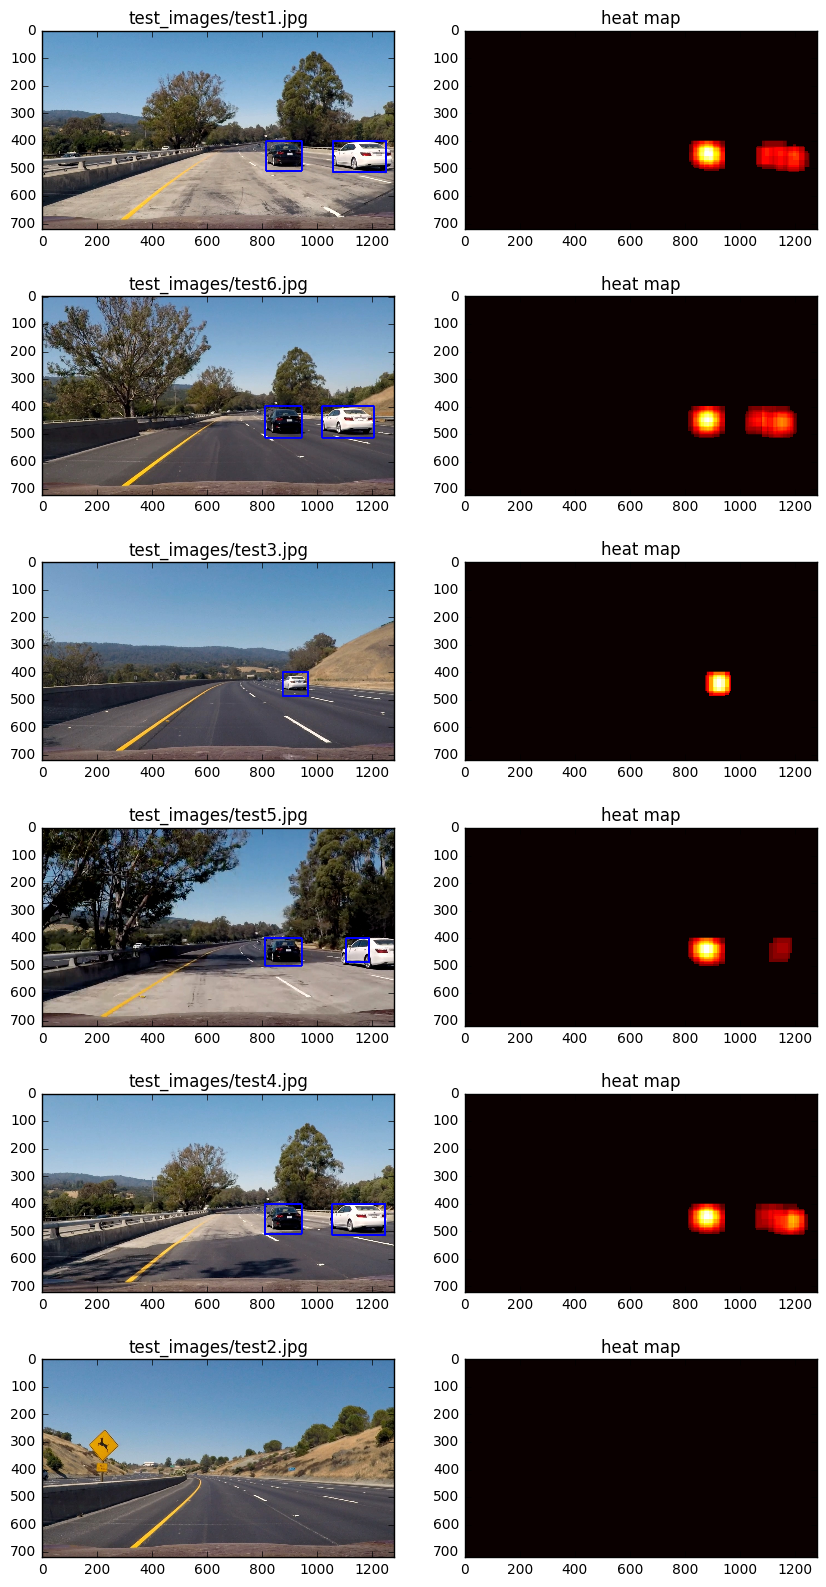

In [95]:
# Apply threshold to heatmap to correct for false positives found in the image 

out_images = [] # Array for output images
out_titles = [] # Array for output plot titles

# Search Area for Image
ystart = 400
ystop = 656
xstart = 540
xstop = 1280

# Go through each test image and apply find_cars() function that uses modified sliding windows method to detect cars
for img_src in example_images:
    img = mpimg.imread(img_src) # Read image
    
    # Detect cars at different scales and steps 
    out_img, img_boxes, heat_map1 = find_cars(img, 0.9, step=2)
    out_img, img_boxes, heat_map2 = find_cars(img, 1.4, step=2)
    out_img, img_boxes, heat_map3 = find_cars(img, 1.2, step=2)
    out_img, img_boxes, heat_map4 = find_cars(img, 1.6, step=2)
    
    # Append all heatmaps
    heat_map = heat_map1 + heat_map2 + heat_map3 + heat_map4
    
    # Apply threshold to heatmap 
    heat_map[heat_map <= 3] = 0
    
    # Label the hotspots of the heatmap 
    labels = label(heat_map)
    
    # Draw single box corresponding to the hotspots found 
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    # Append output images and corresponding output plot titles
    out_images.append(draw_img)
    out_images.append(heat_map)
    out_titles.append(img_src)
    out_titles.append('heat map')

# Visualize boxes on images
fig = plt.figure(figsize=(10, 20), dpi = 300)
visualize(fig, 6, 2, out_images, out_titles)
plt.savefig('output_images/threshold_heatmaps.png')

# Video Process and Generation

In [99]:
# Class to keep track of last 10 heatmaps
class Track():
    def __init__(self):
        # Array that contains heatmaps
        self.heat_maps = []

In [100]:
# Initialize Track class 
heat = Track()

# Search Area for each image 
ystart = 400
ystop = 656
xstart = 540
xstop = 1280

# # Function to process each image from video
def process(img):
    # If length of heatmap array exceeds 9 elements then drop the last element in the array 
    if len(heat.heat_maps) > 9:
        heat.heat_maps = heat.heat_maps[-9:]
        
    # Detect cars at different scales and steps 
    out_img, img_boxes, heat_map1 = find_cars(img, 0.9, step=2)
    out_img, img_boxes, heat_map2 = find_cars(img, 1.4, step=2)
    out_img, img_boxes, heat_map3 = find_cars(img, 1.2, step=2)
    out_img, img_boxes, heat_map4 = find_cars(img, 1.6, step=2)
    
    # Append all heatmaps
    heat_map = heat_map1 + heat_map2 + heat_map3 + heat_map4
    
    # Append accumulated heatmap into heatmaps array 
    heat.heat_maps.append(heat_map)

    # Take the mean of the last 10 heatmaps
    heat_map = np.mean(heat.heat_maps, axis = 0)
    
    # Apply threshold to heatmap
    heat_map[heat_map <= 3.2] = 0
    
    # Label the hotspots of the heatmap
    labels = label(heat_map)
    
    # Draw single box corresponding to the hotspots found 
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    
    return draw_img

In [114]:
# Process test video generated from sequence of frames from project video 

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Process input video and generate output video
test_output = 'output_testing1.mp4'
clip = VideoFileClip("testing1.mp4") # Function expects color images
test_clip = clip.fl_image(process)
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video output_testing1.mp4
[MoviePy] Writing video output_testing1.mp4


 99%|█████████▉| 151/152 [01:33<00:00,  1.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_testing1.mp4 



In [101]:
# Process project video

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Process input video and generate output video
test_output = 'test_output1.mp4'
clip = VideoFileClip("project_video.mp4")
test_clip = clip.fl_image(process) # Function expects color images
test_clip.write_videofile(test_output, audio=False)

[MoviePy] >>>> Building video test_output1.mp4
[MoviePy] Writing video test_output1.mp4


100%|█████████▉| 1260/1261 [13:37<00:00,  1.57it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output1.mp4 

